In [187]:
import pandas as pd
import os


DATA_FILEPATH = "data/CAC40.csv"

def fetch_data():
    """Import the data from csv to pd dataframe"""
    relaviteFilepath = os.path.join(os.path.abspath(''), DATA_FILEPATH)
    return pd.read_csv(relaviteFilepath)

# df stands for dataframe. This is the object that we will manipulate throughouht the notebook
cac40df = fetch_data()

# 1. From the list of companies and market index that you have selected: Analyze the relationship between the daily returns and the value of one feature.
* Do we see a strong correlation?
* Can you generate new (computed) feature?
* which daily return pattern implies the presence of a given pattern?

# Daily return

First, let's calculate the daily return again. We will calculate with the formula:\
$R_{t+1}$ = ($P_{t+1}$ - $P_{t}$) / $P_{t}$\
Which is the same formula as :\
 $R_{t}$ = ($P_{t}$ - $P_{t-1}$) / $P_{t-1}$\
With R the daily Return, and P beeing the Price. We have to decide on a convention - As per the class standard, we will fix P as the closing price.

In [188]:
cac40df["Daily_return"] = (cac40df["Close"] - cac40df["Close"].shift(1)) / cac40df["Close"].shift(1)
cac40df

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_return
0,1990-03-01,1836.000000,1838.000000,1827.000000,1832.000000,1832.000000,0,NaN
1,1990-03-02,1831.000000,1860.000000,1831.000000,1860.000000,1860.000000,0,0.015284
2,1990-03-05,1866.000000,1874.000000,1862.000000,1874.000000,1874.000000,0,0.007527
3,1990-03-06,1869.000000,1875.000000,1866.000000,1872.000000,1872.000000,0,-0.001067
4,1990-03-07,1874.000000,1881.000000,1874.000000,1880.000000,1880.000000,0,0.004274
...,...,...,...,...,...,...,...,...
7999,2021-09-15,6654.830078,6659.270020,6577.020020,6583.620117,6583.620117,81904200,-0.010424
8000,2021-09-16,6613.709961,6663.410156,6612.160156,6622.589844,6622.589844,79574500,0.005919
8001,2021-09-17,6679.450195,6697.080078,6551.620117,6570.189941,6570.189941,214025500,-0.007912
8002,2021-09-20,6450.390137,6471.089844,6389.620117,6455.810059,6455.810059,120069400,-0.017409


We have the daily return value as computed in the course. It is a number in % (So independant of the scale of the selected index). Now we will proceed in steps:
* Compare daily return to our features
* Create new computed features (We will select a few from the course)
* Try to determine patterns

From the course, we have the features list: _As feature, you have previous prices / daily returns / volume_\
First Let's create a function that will help us

In [189]:
#Define a general method as we will compare metrics/features with our daily return
import matplotlib.pyplot as plt
import numpy as np

def compare_daily_returns(curve, label, colors = "purple"):
    x = np.linspace(0, len(cac40df), len(cac40df))

    fig, axs = plt.subplots(2)

    axs[0].plot(x, cac40df["Daily_return"], label="Daily return", color = "blue")
    axs[0].legend()

    axs[1].plot(x, curve, label=label, color=colors)
    axs[1].legend()

    plt.show()

Now compare the closing price and the volume to the daily returns

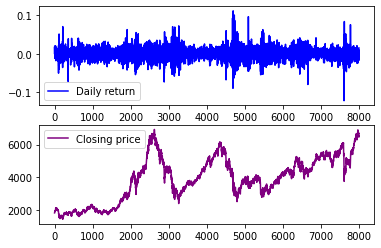

In [190]:
#Closing price
compare_daily_returns(cac40df.Close, "Closing price")

The closing price alone seems hardly a good indicator of the daily return on its own.\
On one hand, we see that the spikes are of course simultaneous as the daily return is calculated from the closing prices.\
On the other hand, although the daily return is directly extracted from the closing price, It seems very limtied in use (can only use 2 consecutive values) and the trends are not visible that easily. As such, we want better predictors - as in, we want to inspect trends and not just a price.\
\
Now we try with the volume.

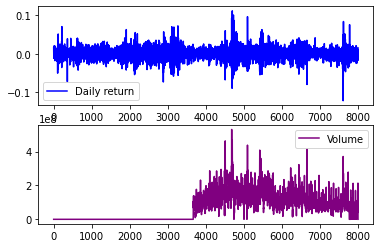

In [191]:
#Volume
compare_daily_returns(cac40df["Volume"], "Volume")

The volume seem to have some kind of correlation as some spikes (up and down) seem synced to the daily returns.\
\
Now let's try to compute some interestring trend predictors from the course.\
We have, as types of indicators:
* overlay
* volatility
* oscillators

We will do one of each. Let's start with the moving average.

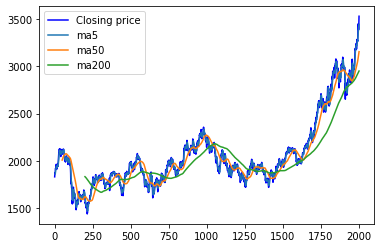

In [192]:
#First prepare the figure with the closing price and daily return
u = 0
v = 2000

x = np.linspace(u, v, v-u)


plt.plot(x, cac40df["Close"][u:v], label="Closing price", color="blue")

maWindows = [5, 50, 200]
for maWindow in maWindows:
    colName = f"ma{maWindow}"
    cac40df[colName] = cac40df["Close"].rolling(maWindow).mean()
    plt.plot(x, cac40df[colName][u:v], label=colName)


plt.legend()

plt.show()

As discussed in the course, the meeting point between the MA and the curve seem to be good indicators of a change of trend, although the MA5 is way too close to the curve to bring any valuable information. The MA200 seem like a better indicator.\

Now with the exp moving average

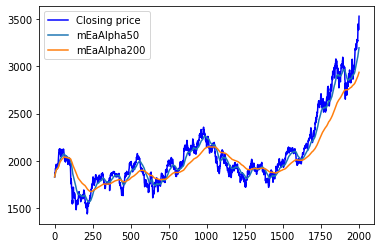

In [193]:
#First prepare the figure with the closing price and daily return
u = 0
v = 2000

x = np.linspace(u, v, v-u)


plt.plot(x, cac40df["Close"][u:v], label="Closing price", color="blue")

#Determine a k, in class we saw k=2
k=2
#Same as before get multiple windows
maWindows = [50, 200]
for maWindow in maWindows:
    #Calculate alpha
    alpha = k / (maWindow + 1)
    #Create col
    colName = f"mEaAlpha{maWindow}"
    cac40df[colName] = cac40df["Close"].ewm(alpha=alpha).mean()
    plt.plot(x, cac40df[colName][u:v], label=colName)

plt.legend()

plt.show()

The MEA seem to be a little less rocky than the MA, although the inforamtion seem to be of the same kind. the meeting of the curve with the closing price seem to be either a change of trend or a plateau - this seems to indicate that a "flat" trend could be benefical (so, 3 labels instead of 2).\
\
Now, off to the Volatility ! For that we'll use the Bollinger bands.

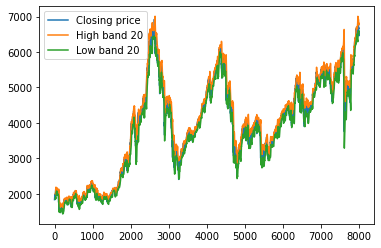

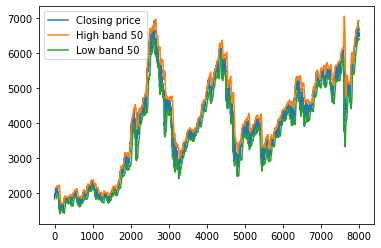

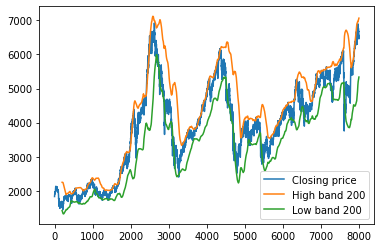

In [194]:
x = np.linspace(0, len(cac40df), len(cac40df))
maWindows = [20, 50, 200]
for maWindow in maWindows:
    # calculate mean rolling
    mean = cac40df["Close"].rolling(maWindow).mean()
    # calculate std rolling
    std = cac40df["Close"].rolling(maWindow).std()
    # calculate high and low band
    high = mean + 2*std
    low = mean - 2*std
    # Plot
    plt.plot(x, cac40df["Close"], label=f"Closing price")
    plt.plot(x, high, label=f"High band {maWindow}")
    plt.plot(x, low, label=f"Low band {maWindow}")
    plt.legend()
    plt.show()

I should definitely put the resolution down for the 20 and 50. The idea is very clearly shown on the band 200: When the closing price meets the high band, then a sell is probably recommended. Similarly, when the closing price curve meets the low band, it can be interpreted as a good candidate for a buy signal.

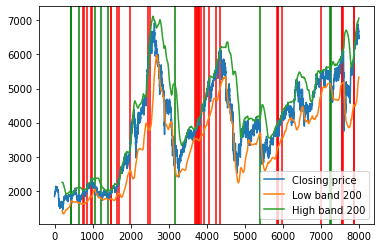

In [195]:
x = np.linspace(0, len(cac40df), len(cac40df))

meanPrice = cac40df["Close"].mean()
threshold = meanPrice * 0.0004

maWindows = 200
# calculate mean rolling
mean = cac40df["Close"].rolling(maWindow).mean()
# calculate std rolling
std = cac40df["Close"].rolling(maWindow).std()
# calculate high and low band
cac40df["Boll_bands_high_200"] = mean + 2*std
cac40df["Boll_bands_low_200"] = mean - 2*std

cac40df["low_meeting"] = abs(cac40df["Close"] - cac40df["Boll_bands_low_200"]) < threshold
cac40df["high_meeting"] = abs(cac40df["Boll_bands_high_200"] - cac40df["Close"]) < threshold

for i in range(len(cac40df)):
    if cac40df.at[i, "low_meeting"]:
        plt.axvline(i, color="green")
    if cac40df.at[i, "high_meeting"]:
        plt.axvline(i, color="red")

# Plot
plt.plot(x, cac40df["Close"], label=f"Closing price")
plt.plot(x, cac40df["Boll_bands_low_200"], label=f"Low band {maWindow}")
plt.plot(x, cac40df["Boll_bands_high_200"], label=f"High band {maWindow}")

plt.legend()
plt.show()

The above plot shows that a simple buy/sell signal can be derived from the Bollinger bands. Now for the oscillators, we'll use the stochastic oscillator

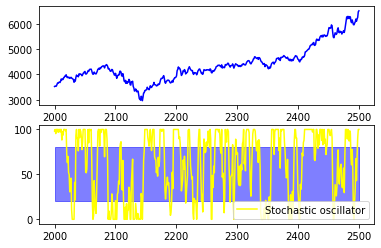

In [196]:
mw = 14
cac40df[f"min{mw}"] = cac40df["Close"].rolling(mw).min()
cac40df[f"max{mw}"] = cac40df["Close"].rolling(mw).max()
cac40df["Stochastic"] = 100 * ((cac40df["Close"] - cac40df[f"min{mw}"]) / (cac40df[f"max{mw}"] - cac40df[f"min{mw}"]))

u,v = 2000,2500

x = np.linspace(u, v, v-u)

# Plot
fig, axs = plt.subplots(2)

axs[0].plot(x, cac40df["Close"][u:v], label=f"Closing price", color="blue")

axs[1].plot(x, cac40df["Stochastic"][u:v], label=f"Stochastic oscillator", color="yellow")
axs[1].fill_between(x, 20, 80,where=x,color='b',alpha=.5)


plt.legend()
plt.show()

As for the stochastic oscillator - I find mine to be very varying and not stable, it is hard to really see a pattern with the closing price.

# 2. Using the titanic dataset:
* What is the relationship between predictors(class, age ) and survival?
* What was the survival rate of women?
* What is the variation of survival rate based on number of siblings the passenger had on the ship?
* What is the variation of survival rate based on number of parents/children the passenger had on the ship?

In [197]:
#First, we import the titanic df
DATA_FILEPATH = "data/titanic.csv"

def fetch_data():
    """Import the data from csv to pd dataframe"""
    relaviteFilepath = os.path.join(os.path.abspath(''), DATA_FILEPATH)
    return pd.read_csv(relaviteFilepath)

# df stands for dataframe. This is the object that we will manipulate throughouht the notebook
titanicdf = fetch_data()
titanicdf

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


# What is the relationship between predictors(class, age ) and survival?
Let's see how the class and then the age relate to the survival rate. First with the class

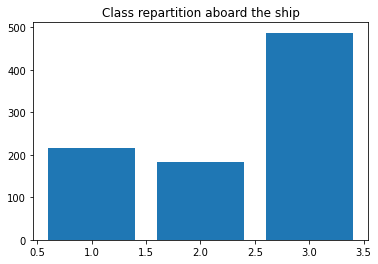

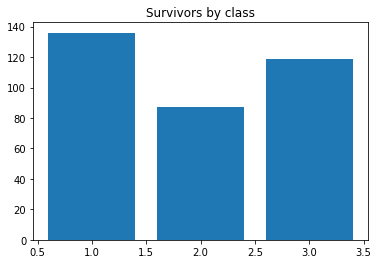

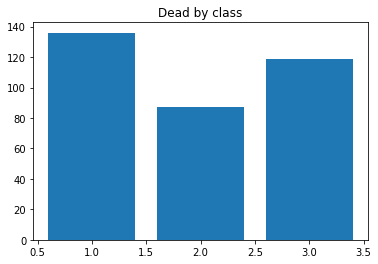

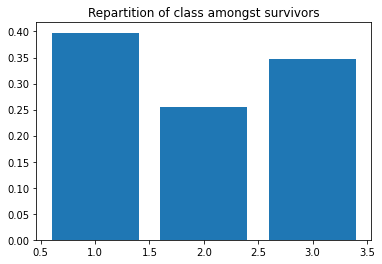

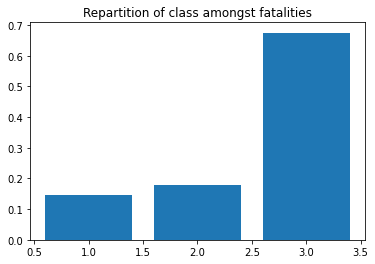

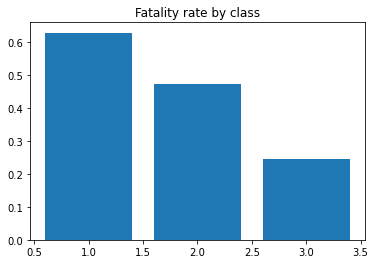

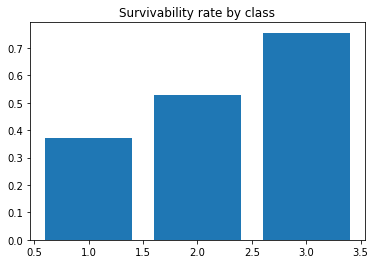

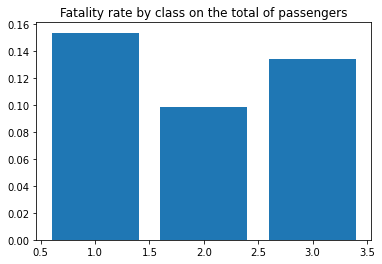

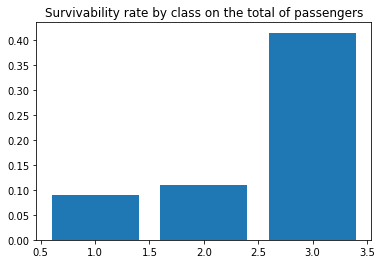

In [198]:
classRepartition = [len(titanicdf[titanicdf.Pclass == i]) for i in range(1,4)]
plt.bar(range(1,4), classRepartition)
plt.title("Class repartition aboard the ship")
plt.show()

survivors = []
fatalities = []

for i in range(1,4):
    survivors.append(len(titanicdf[(titanicdf.Pclass == i) & (titanicdf.Survived == 1)]))
    fatalities.append(len(titanicdf[(titanicdf.Pclass == i) & (titanicdf.Survived == 0)]))


plt.bar(range(1,4), survivors)
plt.title("Survivors by class")
plt.show()
plt.bar(range(1,4), survivors)
plt.title("Dead by class")
plt.show()

classBySurvivor = []
classByFatality = []

totalSurvivors = sum(survivors)
totalFatalities = sum(fatalities)

for i in range(1,4):
    classBySurvivor.append(survivors[i-1] / totalSurvivors)
    classByFatality.append(fatalities[i-1] / totalFatalities)

plt.bar(range(1,4), classBySurvivor)
plt.title("Repartition of class amongst survivors")
plt.show()

plt.bar(range(1,4), classByFatality)
plt.title("Repartition of class amongst fatalities")
plt.show()

survivorRates = []
fatalityRates = []

for i in range(1,4):
    survivorRates.append(survivors[i-1] / len(titanicdf[titanicdf.Pclass == i]))
    fatalityRates.append(fatalities[i-1] / len(titanicdf[titanicdf.Pclass == i]))

plt.bar(range(1,4), survivorRates)
plt.title("Fatality rate by class")
plt.show()

plt.bar(range(1,4), fatalityRates)
plt.title("Survivability rate by class")
plt.show()

totalsurvivorRates = []
totalfatalityRates = []

for i in range(1,4):
    totalsurvivorRates.append(survivors[i-1] / len(titanicdf))
    totalfatalityRates.append(fatalities[i-1] / len(titanicdf))

plt.bar(range(1,4), totalsurvivorRates)
plt.title("Fatality rate by class on the total of passengers")
plt.show()

plt.bar(range(1,4), totalfatalityRates)
plt.title("Survivability rate by class on the total of passengers")
plt.show()



From these bargraphes, I get that the survivability doesn't vary much, but the fatality rate is enormous amongst third class.\

Now, second objective:
# What was the survival rate of women?

In [199]:
selectorWomen = titanicdf.Sex.eq('female')
selectorMen = titanicdf.Sex.eq('male')
selectorSurvive =  titanicdf.Survived.eq(1)

survivabilityWomen = (len(titanicdf[selectorWomen & selectorSurvive]) / len(titanicdf[selectorWomen]))
print(f"The survivability rate of women is {100*survivabilityWomen} %")

survivabilityMen = (len(titanicdf[selectorMen & selectorSurvive]) / len(titanicdf[selectorWomen]))
print(f"By comparison, The survivability rate of mens is {100*survivabilityMen} %")


The survivability rate of women is 74.20382165605095 %
By comparison, The survivability rate of mens is 34.71337579617834 %


* What is the variation of survival rate based on number of siblings the passenger had on the ship?

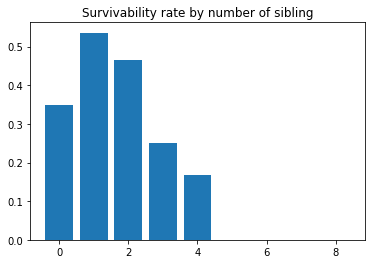

In [200]:
maxSiblings = titanicdf["Siblings/Spouses Aboard"].max()
siblingVariation = {}
for i in range(maxSiblings+1):
    selectorSibling = titanicdf["Siblings/Spouses Aboard"] == i
    selectorSurvivability = titanicdf.Survived == 1
    if len(titanicdf[selectorSibling]) > 0:
        siblingVariation[i] = (len(titanicdf[selectorSibling & selectorSurvivability]) / len(titanicdf[selectorSibling]))

plt.bar(siblingVariation.keys(), siblingVariation.values())
plt.title("Survivability rate by number of sibling")
plt.show()

The survivability rate goes down if the number of siblings go up. The best one is at 1, whereas all of the 5,6,7,8 siblings did not survive. This could be reflective of a pattern (too many siblings -> less survivability) or this could be the result of a random lack of chance, although a downward trend seems present.

# What is the variation of survival rate based on number of parents/children the passenger had on the ship?

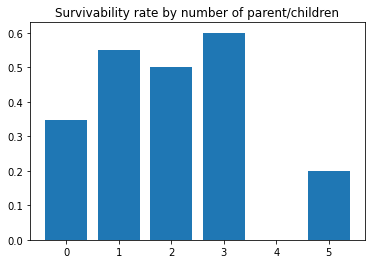

In [201]:
maxSiblings = titanicdf["Parents/Children Aboard"].max()
siblingVariation = {}
for i in range(maxSiblings):
    selectorSibling = titanicdf["Parents/Children Aboard"] == i
    selectorSurvivability = titanicdf.Survived == 1
    if len(titanicdf[selectorSibling]) > 0:
        siblingVariation[i] = (len(titanicdf[selectorSibling & selectorSurvivability]) / len(titanicdf[selectorSibling]))

plt.bar(siblingVariation.keys(), siblingVariation.values())
plt.title("Survivability rate by number of parent/children")
plt.show()

The survavibility rate by number of parent/children is very low for 4,5 but is very similar to 1-3. 0 seem to also be lower than the medium bracket.\
We could think that having no one or too much people in the family is detrimental, but there is not a very clear trend such as the one seen above.\
Fortunately for humans but unfortunately for the data, we don't have much databases of titanic drowning to know if this hypothesis seem validated across multiple ships.